In [1]:
# from iotbx import cif
# from iotbx.data_manager import DataManager
# import os
# os.environ["MMTBX_CCP4_MONOMER_LIB"] = "/Users/user/software/phenix/modules/chem_data/geostd"

In [2]:
import sys
sys.path.append("../phenix_fragments/")

In [3]:
from utils.mp import pool_with_progress

In [4]:
from graph.utils import build_atom_graph_from_mol, build_fragment_graph

/net/cci/cschlick/miniconda3/envs/restraintsML/envs/restraintsML6/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from mol.mols import MolInputGeo, Mol
from pathlib import Path
from mol.cif import load_cif_file, guess_cif_format
from mol.rdkit import validate_rdkit_mol

In [6]:
from fragmentation.fragmenters import BondFragmenter, AngleFragmenter
from graph.molgraph import MolGraph, MolGraphDataset
from graph.message_passing import MessagePassingBonded
from graph.readout import ReadoutSimple

In [7]:
import torch

In [8]:
# dm = DataManager()
# file = Path("../data/PO_data/12AS/output/12AS.updated.pdb")
# dm.process_model_file(str(file))
# dm.process_restraint_file("../data/PO_data/12AS/output/restraints/AMP.cif")
# model = dm.get_model()
# model.process(make_restraints=True)

# mol = Mol.from_cctbx_model(model)
# molecule_id = file.stem.split(".")[0]
# mol.molecule_id = molecule_id

In [9]:
folder = Path("/dev/shm/cschlick/geostd/")
files = [file for file in folder.glob("**/*") if file.suffix == ".cif" and "ccd" not in file.name and "lib" not in file.name]

In [10]:
known_blacklist = ['R79', 'R46', 'R3E', 'RDR', 'R19', 'RIG', 'R3B', 'RE3', 'RE0', 'R04', 'R01', 'RRP', 'R03', 'R17', 'R1A', 'R71', 'RTQ', 'RTR', 'U', 'UN2', 'UZ7', 'U49', 'U66', 'U5Y', 'URG', 'UIZ', '9ZM', '9NV', '95A', '9NE', '9NR', '9NF', '0A8', '0CS', '0BR', '07O', '0AH', '0N1', '0AK', '0E2', '0GM', '0E3', '0D5', '030', '0FL', '000', '02O', '0PN', '02L', '013', '01F', '0AF', '0ZM', '0A1', '0AR', '0LF', '0BN', '7C2', '7AZ', '7C0', '7NX', '7LT', '7LW', 'IV7', 'ILX', 'IBU', 'IAM', 'IRI', 'I21', 'IEL', 'I2M', 'IYR', 'INM', 'ILE', 'ICY', 'IZO', 'NEP', 'NDT', 'ND4', 'NKJ', 'N31', 'NGH', 'N2C', 'NDG', 'NDP', 'NAL', 'NMM', 'NBQ', 'NOT', 'NMQ', 'NMR', 'NCY', 'NCO', 'NAG', 'NNH', 'NYS', 'NLE', 'NMC', 'low', 'NO', 'NIY', 'N1B', 'N0P', 'NPI', 'NPH', 'NGA', 'GME', 'GLU', 'GVL', 'GPL', 'G2O', 'G', 'GEK', 'GD', 'GHG', 'GT9', 'GAL', 'GLJ', 'GLY', 'G9R', 'GLN', 'GOV', 'GVB', 'GND', '6CW', '6VB', '6QG', '6Q1', '6HN', '6CH', '6VJ', '6CL', '6T3', 'ZBZ', 'Z70', 'ZCL', 'ZSW', 'ZSV', 'Z01', 'ZKG', 'ZRL', 'ZZD', '1PA', '12W', '1TY', '143', '193', '1ZX', '1TQ', '1X6', '10R', '82J', '8Q4', '85A', 'TYI', 'TCQ', 'TNB', 'T5B', 'TBR', 'TLY', 'TYX', 'TY9', 'TYO', 'TYN', 'TY8', 'TYY', 'TNR', 'TBG', 'TIS', 'TPQ', 'TRN', 'TRX', 'TRO', 'TEF', 'T0I', 'THR', 'TS9', 'TQQ', 'TQI', 'TRP', 'TRF', 'TEO', 'TIH', 'TPJ', 'T11', 'T3Y', 'TUB', 'T5H', 'TC9', 'TY5', 'TTS', 'TYQ', 'T58', 'TYR', 'TY2', 'TYS', 'TD', 'SIB', 'SEB', 'SIA', 'SDP', 'S1H', 'SEP', 'SD4', 'S2P', 'SHC', 'SRM', 'SER', 'SLZ', 'SUN', 'SLL', 'SY9', 'SVW', 'SVV', 'SAH', 'SCS', 'SNC', 'S5W', 'SCH', 'SMC', 'SVZ', 'SME', 'SVX', 'SVY', 'SXE', 'SEM', 'AN8', 'A5N', 'ALA', 'ALC', 'AAD', 'AZY', 'AR4', 'AGT', 'ASP', 'ARV', 'ARS', 'AGS', 'APM', 'ARG', 'AGQ', 'A', 'ADP', 'ASN', 'ASL', 'AHP', 'A25', 'AGM', 'ARO', 'ALN', 'ALY', 'AAH', 'AZS', 'AD', 'A9A', 'AR', 'FEO', 'FRQ', 'FHO', 'FHL', 'FLT', 'FUC', 'FLA', 'FOL', 'FNH', 'FU0', 'FT6', 'FTY', 'F4S', 'FWQ', 'FRM', 'F2F', 'FFM', 'F3S', 'link', 'exafs', 'crg', 'alpha2-6', 'OTY', 'ON6', 'OC1', 'OCS', 'OAZ', 'OXX', 'O7N', 'OBS', 'OLZ', 'OBF', 'OMH', 'OHI', 'OEX', 'ORQ', 'O12', 'OSE', 'OM3', 'OCY', 'OM2', 'ONH', 'OTQ', 'OAS', 'OMT', 'OTB', 'OXV', 'ONL', 'HIC', 'HS8', 'HIS', 'HPE', 'HQA', 'HGL', 'HIQ', 'H8T', 'HTI', 'HVA', 'HNC', 'HCS', 'HZP', 'HLU', 'HAR', 'HOX', 'HFS', 'HRP', 'HRG', 'HHK', 'list', 'MYK', 'MCS', 'low', 'MO1', 'MMO', 'MAN', 'MTY', 'MXI', 'MB0', 'MBQ', 'MLX', 'MLY', 'MNQ', 'MIR', 'MEQ', 'ME0', 'M2S', 'MIS', 'MSL', 'MHS', 'MET', 'M0H', 'MGG', 'M2L', 'MEN', 'MF3', 'MSE', 'MHO', 'M3L', 'MT2', 'MYW', 'MUT', 'ML3', 'MLG', 'JJL', 'JJJ', 'JJK', 'JN1', 'pur', 'pur', 'pyr', 'pyr', 'rna2p', 'rna3p', 'rna3p', 'rna2p', 'CAB', 'CYS', 'CYR', 'CY1', 'CYG', 'CY0', 'CYQ', 'CLG', 'C6C', 'CY4', 'CTE', 'CD', 'CYW', 'CME', 'CLA', 'CGA', 'CSS', 'CSD', 'CS3', 'CGU', 'CS1', 'CSU', 'C', 'CSA', 'C0Q', 'C1X', 'plane', 'low', 'CPC', 'CSO', 'CSJ', 'CU9', 'CLZ', 'CLO', 'CO4', 'C6J', 'CN4', 'CYJ', 'C5C', 'CCS', 'low', 'C6M', 'CLH', 'CML', 'DGD', 'DPL', 'DH8', 'D3O', 'DT0', 'DON', 'DAE', 'DBL', 'DBY', 'DYS', 'low', 'DMZ', 'DV0', 'DO2', 'DB5', 'D4P', 'DAH', 'DMK', 'DVV', 'DNS', 'DMH', 'DVT', 'D8U', 'DB0', 'DE0', 'DIR', 'DPP', 'DPQ', 'DE6', 'DDE', 'VAL', 'VZ7', 'VLL', 'VHA', 'VHC', 'VFY', 'VR0', 'VJ6', 'Q3E', 'QPA', 'QEV', 'QDW', 'Q4B', 'Q8T', 'Q8B', 'Q7Z', 'QMM', 'Q7H', 'QLJ', 'Q7K', 'Q41', 'Q7Q', 'Q7V', 'Q4Y', 'Q2Z', 'QEY', '4YM', '4BF', '4CF', '4DP', '4DB', '4HT', '4PH', '406', '4FW', '4IN', '4LA', 'X5M', 'XLS', 'XMF', 'XX1', 'XCN', 'XME', 'XX2', 'XS1', 'X3P', 'low', 'XMI', 'XW1', 'XMJ', '3GL', '3DB', '3EG', '32T', '3CF', '3TY', '3AH', '3NK', '3AR', '35Y', 'E61', 'E6P', 'E4Y', 'ECX', 'EAQ', 'ESB', 'EFC', 'ESC', 'EEM', 'E19', 'EQ1', 'E9A', 'E4G', 'EXY', 'E5A', 'E6M', 'EVB', 'E5D', 'EN3', 'E51', 'E5P', 'E6J', 'BFQ', 'BPH', 'BS3', 'BGG', 'BG1', 'BMA', 'BUC', 'BTR', 'BCL', 'BLT', 'BCB', 'BTK', 'B4E', 'BMY', 'BCS', 'B3U', 'BIF', 'BIQ', 'KYN', 'K44', 'KNB', 'KOR', 'KKH', 'KQB', 'K0X', 'KPI', 'KST', 'KYQ', 'low', 'K9K', 'KCX', 'LED', 'LPG', 'LGY', 'LEF', 'LE1', 'LET', 'LEU', 'LP6', 'L8G', 'LAL', 'LLO', 'LLY', 'LYZ', 'LLZ', 'LVT', 'LYU', 'LA2', 'LMF', 'L7G', 'LMT', 'LLP', 'LYF', 'LYS', 'LBY', 'LCK', 'LDH', 'L3J', 'L3Z', 'L3M', '2TY', '2P0', '2FM', '2HF', '200', '2AG', '2CO', '26E', '2MR', '267', '2XA', '25Y', '2MT', '200-checkpoint', 'YNM', 'YM6', 'YCM', 'YOF', '5WQ', '58T', '5CS', '56A', 'plane', 'PBF', 'PL9', 'PY8', 'PTH', 'PYX', 'PNQ', 'PTM', 'PBB', 'P7H', 'P3Q', 'PEC', 'P1L', 'PRJ', 'PRK', 'PHE', 'PRO', 'PE1', 'PSH', 'PFF', 'PF5', 'PSU', 'PPN', 'PHI', 'PRR', 'PAT', 'PLP', 'PTR', 'P6Q', 'P6S', 'P6D', 'PYA', 'PM3', 'PAQ', 'W37', 'WFP']
files= [file for file in files if file.stem.split("_")[-1] not in known_blacklist]

In [11]:
import tqdm
import numpy as np

In [12]:
mol = Mol.from_file_geocif(files[0]) # maybe necessary to set class attrs

In [13]:
def worker(file):
  mol = Mol.from_file_geocif(file)
  rdmol = mol.rdkit_mol
  return mol
mols = pool_with_progress(worker,files,nproc=32)

nproc=32: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22134/22134 [01:00<00:00, 366.23it/s]


In [14]:
mgraphs = []
failed_mols = []
debug = False
for mol in tqdm.tqdm(mols):
  try:
    mgraph = MolGraph(mol=mol,
                      
                      fragmenter=AngleFragmenter(exclude_elements=[]),
                      labelers = {"angle_value":lambda frags: frags.angle_value,
                                 "angle_ideal":lambda frags: frags.angle_ideal},
                      
                      #fragmenter=BondFragmenter(exclude_elements=["H"]),
                      # labelers = {"distance_ideal":lambda frags: frags.distance_ideal,
                      #            "distance":lambda frags: frags.distance},
                      skip_hydrogens=False,
                      frag_name="fragment")
    mgraphs.append(mgraph)
  except:
    failed_mols.append(mol)
    if debug:
      raise

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22134/22134 [03:19<00:00, 110.76it/s]


In [15]:
import sys
sys.path.append("../../../")

In [16]:
# from graph.message_passing import MessagePassingBonded
# from graph.readout import ReadoutJanossyLinear
# import copy

In [17]:
# clear_attrs = [label_name+"_pred","h"]+["h%s"%i for i in range(fragment_size)]
# atom_name = "atom"
# fragment_name = "fragment"
# for mgraph in mgraphs:
#   for attr in clear_attrs:
#     if attr in mgraph.fragment_graph.nodes[atom_name].data:
#       if attr != "h0":
#         del mgraph.fragment_graph.nodes[atom_name].data[attr]
#     if attr in mgraph.fragment_graph.nodes[fragment_name].data:
#       del mgraph.fragment_graph.nodes[fragment_name].data[attr]

In [18]:

label_name = "angle_ideal"
dataset = MolGraphDataset(mgraphs)
g = dataset.fragment_graph
atom_feature_shape = tuple(g.nodes["atom"].data["h0"].shape)
#hidden_units = 64
# message_passing = MessagePassingBonded(feature_units=atom_feature_shape[1],
#                                        hidden_units=hidden_units,
#                                        nlayers=4,
#                                        )

# #readout = ReadoutSimpleLinear(hidden_units*2,hidden_units*2,1,n_hid_layers=1,label_name=label_name)
# fragment_size = 3
# # readout = ReadoutSimple(hidden_units,
# #                         hidden_units,
# #                         1,
# #                         n_hid_layers=3,
# #                         fragment_size=fragment_size,
# #                         label_name=label_name)
# # readout = ReadoutJanossyLinear(hidden_units*fragment_size,
# #                                hidden_units*fragment_size,
# #                                1,
# #                                n_hid_layers=3,
# #                                label_name=label_name,
# #                                fragment_size=fragment_size)

In [19]:
import sys
sys.path.append("../../PhenixML/")
# make model
import torch.nn as nn
from phenixml.models.message_passing import MessagePassing
from phenixml.models.readout import ReadoutLinearJanossy

# settings
gpuid = 2
n_units = 128
n_layers_mp = 4
fragment_size = 2
feature_units = dataset[0].fragment_graph.nodes["atom"].data["h0"].shape[1]


# Set up message passing
config = []
for n_layer in range(n_layers_mp):
  config+=[n_units,"relu"]

message_passing = MessagePassing(
    feature_units=feature_units) 


# Set up readout
n_layers_readout = 3
config = []
for n_layer in range(n_layers_readout):
  config+=[n_units,"relu"]
  
readout = ReadoutLinearJanossy(
    in_features=n_units, 
    config=config,
    out_features={label_name+"_pred":1},
    fragment_size = fragment_size)

# Sequential message passing, readout
model = nn.Sequential(message_passing,readout)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()

In [20]:
model = torch.nn.Sequential(message_passing,readout)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()

In [21]:
batches = list(dataset.batches(n_batches=4))

In [22]:
gpuid = 0
if gpuid is not None:
  model = model.to("cuda:"+str(gpuid))


# Training loop
epoch_losses = []
n_epoch=500

for epoch in tqdm.tqdm(range(n_epoch)):
  batch_losses = []
  for batch in batches:
    if gpuid is not None:
      batch = batch.to("cuda:"+str(gpuid))
    g = model(batch)
    loss = metric(g.nodes["fragment"].data[label_name],
                  g.nodes["fragment"].data[label_name+"_pred"])
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    batch_losses.append(loss.item())

  epoch_losses.append(np.mean(batch_losses))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:11<00:00,  1.61it/s]


In [23]:
model = model.to("cpu")
g = model(dataset.fragment_graph)

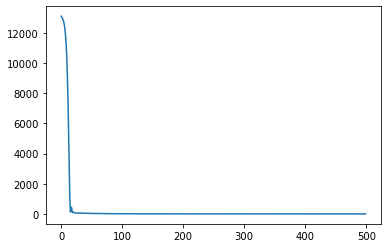

In [24]:
import matplotlib.pyplot as plt
plt.plot(epoch_losses)

In [26]:
import torch

def to_np(tensor):
  return tensor.detach().cpu().numpy()


def to_torch(array):
  return torch.tensor(array,dtype=torch.get_default_dtype())

In [27]:
a,b =(to_np(g.nodes["fragment"].data[label_name][:,0]),
      to_np(g.nodes["fragment"].data[label_name+"_pred"][:,0]))

In [28]:
c,d =(to_np(g.nodes["fragment"].data["angle_value"][:,0]),
      to_np(g.nodes["fragment"].data["angle_ideal"][:,0]))

In [29]:
from utils.plotting import plot_geom_eval

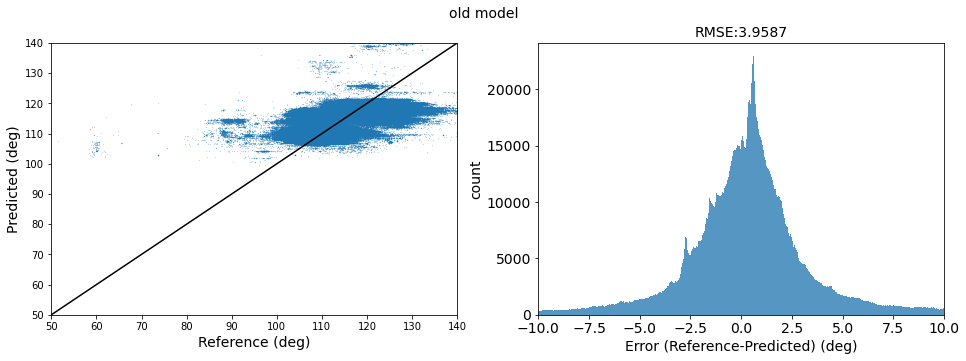

In [30]:
plot_geom_eval(a,b,note="old model",mode="angle")

In [31]:
g

Graph(num_nodes={'atom': 960670, 'fragment': 1730630},
      num_edges={('atom', 'atom_as_0_in_fragment', 'fragment'): 1730630, ('atom', 'atom_as_1_in_fragment', 'fragment'): 1730630, ('atom', 'atom_as_2_in_fragment', 'fragment'): 1730630, ('atom', 'atom_bonded_atom', 'atom'): 1990822},
      metagraph=[('atom', 'fragment', 'atom_as_0_in_fragment'), ('atom', 'fragment', 'atom_as_1_in_fragment'), ('atom', 'fragment', 'atom_as_2_in_fragment'), ('atom', 'atom', 'atom_bonded_atom')])